In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shravankumar9892/image-colorization

!unzip image-colorization.zip

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/shravankumar9892/image-colorization
License(s): CC0-1.0
image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  image-colorization.zip
replace ab/ab/ab1.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ab/ab/ab1.npy           
  inflating: ab/ab/ab2.npy           
  inflating: ab/ab/ab3.npy           
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: l/gray_scale.npy        


In [3]:
!pip install torchsummary

In [4]:
!pip install pytorch_lightning

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
from skimage import io, color
import skimage
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

In [6]:
gray_path = "/content/l/gray_scale.npy"

In [7]:
!wget https://drive.google.com/uc?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069
!mv uc?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069 lena.bmp

--2024-08-04 05:22:58--  https://drive.google.com/uc?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069
Resolving drive.google.com (drive.google.com)... 142.250.141.100, 142.250.141.113, 142.250.141.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069 [following]
--2024-08-04 05:22:58--  https://drive.usercontent.google.com/download?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263222 (257K) [application/octet-stream]
Saving to: ‘uc?id=19xZhsjs_r0tLwtu_Wl5DB5rG26dhw069’

uc?id=19xZhsjs_r0tL 100%[===================>] 257.05K  --.-KB/s    in 0.06s   

2

In [8]:
gray = np.load(gray_path)[:10000]
print(gray.shape)

(10000, 224, 224)


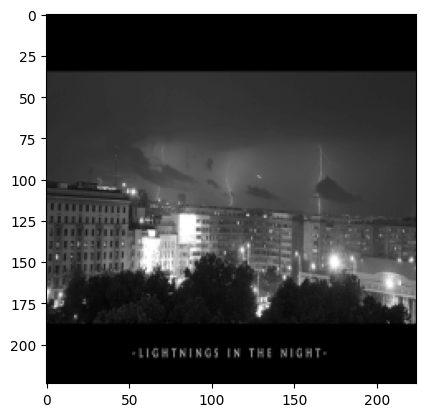

In [9]:
import matplotlib.pyplot as plt
import cv2

def display(img):
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
sample = gray[100]
display(sample)

In [10]:
def LogisticEncryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]
    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    C = round((L*L_y*10**4) % 256)
    C_r = round((L*L_y*10**4) % 256)
    C_g = round((L*L_y*10**4) % 256)
    C_b = round((L*L_y*10**4) % 256)
    x = 4*(S_x)*(1-S_x)
    y = 4*(S_y)*(1-S_y)

    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)
    LogisticEncryptionIm = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N)
            if color:
              C_r =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][0]) % N) ^ ((C_r + key_list[7]) % N)
              C_g =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][1]) % N) ^ ((C_g + key_list[7]) % N)
              C_b =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][2]) % N) ^ ((C_b + key_list[7]) % N)
              row.append((C_r,C_g,C_b))
              C = C_r

            else:
              C = ((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j]) % N) ^ ((C + key_list[7]) % N)
              row.append(C)

            x = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            y = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
                LogisticEncryptionIm.append(row)

    im = Image.new("L", (dimensionX, dimensionY))
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = LogisticEncryptionIm[x][y]
    im.save(imageName.split('.')[0] + "_LogisticEnc.png", "PNG")

In [11]:
def LogisticDecryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]

    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L_x = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L_x *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y

    C = round((L_x*L_y*10**4) % 256)
    I_prev = C
    I_prev_r = C
    I_prev_g = C
    I_prev_b = C
    I = C
    I_r = C
    I_g = C
    I_b = C
    x_prev = 4*(S_x)*(1-S_x)
    y_prev = 4*(L_x)*(1-S_y)
    x = x_prev
    y = y_prev
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)

    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N)
            if color:
                I_r = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_r + key_list[7]) % N) ^ imageMatrix[i][j][0]) + N-key_list[6])%N
                I_g = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_g + key_list[7]) % N) ^ imageMatrix[i][j][1]) + N-key_list[6])%N
                I_b = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_b + key_list[7]) % N) ^ imageMatrix[i][j][2]) + N-key_list[6])%N
                I_prev_r = imageMatrix[i][j][0]
                I_prev_g = imageMatrix[i][j][1]
                I_prev_b = imageMatrix[i][j][2]
                row.append((I_r,I_g,I_b))
                x = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
            else:
                I = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev+key_list[7]) % N) ^ imageMatrix[i][j]) + N-key_list[6])%N
                I_prev = imageMatrix[i][j]
                row.append(I)
                x = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        henonDecryptedImage.append(row)
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageName.split('_')[0] + "_LogisticDec.png", "PNG")

In [12]:
def getImageMatrix(imageName):
    im = Image.open(imageName)
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [13]:
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA')
    pix = im.load()
    image_size = im.size
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

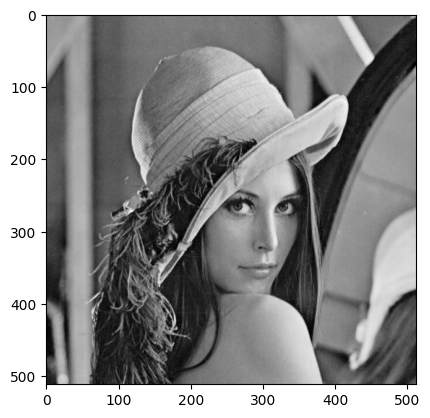

In [14]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import random
from math import log
import cv2
from tqdm import tqdm
image = "lena"
ext = ".bmp"
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im), cmap='gray')

In [15]:
gray = gray / 255
image = "lena"
ext = ".bmp"
gray = gray.reshape((-1,224,224,1))
import torch
from torch import nn
gray = gray.reshape((-1,1,224,224))

In [16]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 8, stride=2, padding=2),  # b, 1, 28, 28
            #nn.ConvTranspose2d()
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

In [17]:
num_epochs = 50
size = gray.shape[0]
batches = 128
print_every = 100
for epoch in range(num_epochs):
    total_loss = 0
    steps = size//batches
    for i in range(0,steps,batches):
        data = gray[i:i+batches]
        tensor_data = (torch.from_numpy(data)).float()
        generated_data = model(tensor_data)
        loss = criterion(generated_data,tensor_data)

        total_loss += loss.item()*data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch:",epoch,"/",num_epochs," Loss:",total_loss/steps)

Epoch: 0 / 50  Loss: 0.1421681550832895
Epoch: 1 / 50  Loss: 0.14180375368167192
Epoch: 2 / 50  Loss: 0.141448974609375
Epoch: 3 / 50  Loss: 0.14110134809445113
Epoch: 4 / 50  Loss: 0.14075829432560846
Epoch: 5 / 50  Loss: 0.14041685446714744
Epoch: 6 / 50  Loss: 0.1400746321066832
Epoch: 7 / 50  Loss: 0.13973107704749474
Epoch: 8 / 50  Loss: 0.13938492995042068
Epoch: 9 / 50  Loss: 0.13903507819542518
Epoch: 10 / 50  Loss: 0.13868194971329126
Epoch: 11 / 50  Loss: 0.1383236127021985
Epoch: 12 / 50  Loss: 0.13795937024630034
Epoch: 13 / 50  Loss: 0.1375885987893129
Epoch: 14 / 50  Loss: 0.137209904499543
Epoch: 15 / 50  Loss: 0.13681986393072668
Epoch: 16 / 50  Loss: 0.1364142100016276
Epoch: 17 / 50  Loss: 0.13598921360113683
Epoch: 18 / 50  Loss: 0.13554143905639648
Epoch: 19 / 50  Loss: 0.13506630139473158
Epoch: 20 / 50  Loss: 0.13455806634364983
Epoch: 21 / 50  Loss: 0.13401252795488405
Epoch: 22 / 50  Loss: 0.13342693524482924
Epoch: 23 / 50  Loss: 0.13279329202114007
Epoch: 24 /

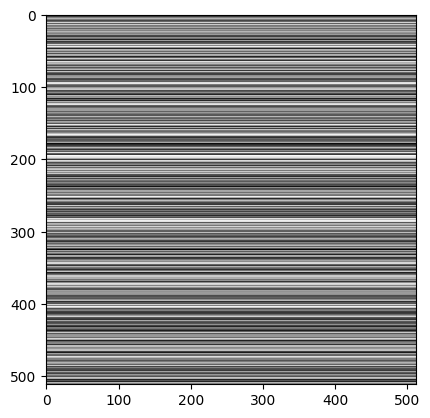

In [18]:
LogisticEncryption("lena.bmp", "1234567890123")
im = Image.open("lena_LogisticEnc.png", 'r')
imshow(np.asarray(im), cmap='gray')

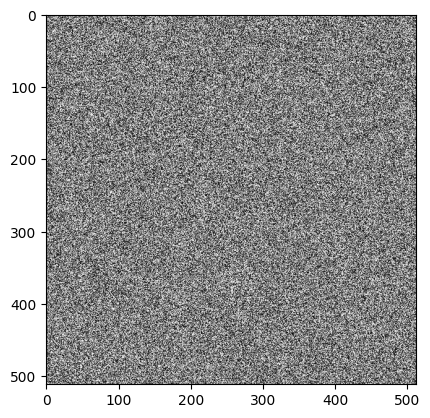

In [19]:
LogisticDecryption("lena_LogisticEnc.png","1234567890123")
im = Image.open("lena_LogisticDec.png", 'r')
imshow(np.asarray(im),cmap='gray')

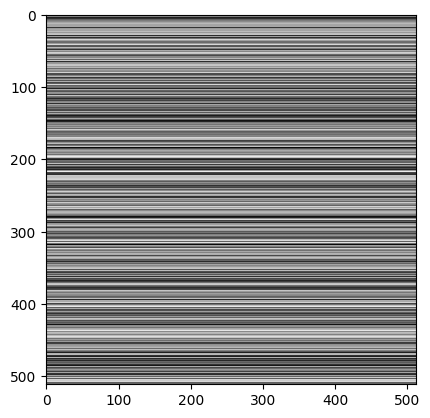

In [20]:
LogisticEncryption(image + ext, key = "findsecretkey")
encryption = Image.open(image + "_LogisticEnc.png", 'r')
imshow(np.asarray(encryption))

(10000, 224, 224)


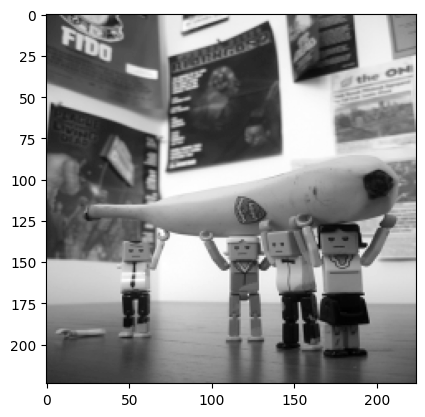

In [21]:
import matplotlib.pyplot as plt
import cv2
gray = np.load(gray_path)[:10000]
print(gray.shape)

def display(img):
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
decryption = gray[600]
display(decryption)

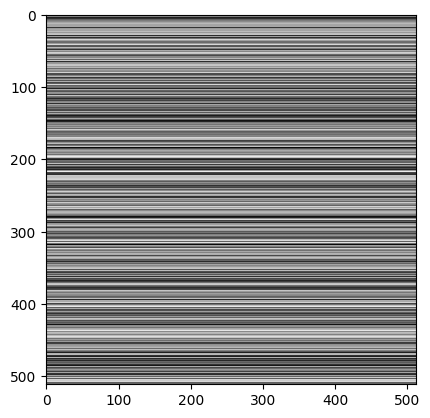

In [22]:
LogisticEncryption(image + ext, key = "findsecretkey")
enc_res = Image.open(image + "_LogisticEnc.png", 'r')
imshow(np.asarray(enc_res))

(10000, 224, 224)


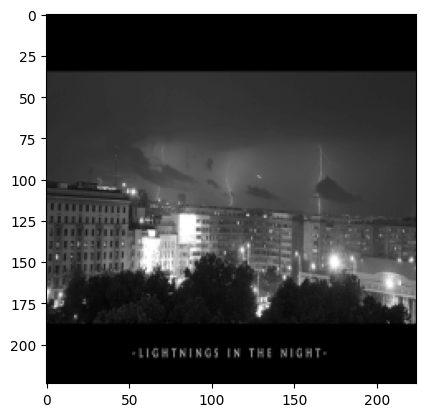

In [23]:
import matplotlib.pyplot as plt
import cv2
gray = np.load(gray_path)[:10000]
print(gray.shape)

def display(img):
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
decrypt = gray[100]
display(decrypt)

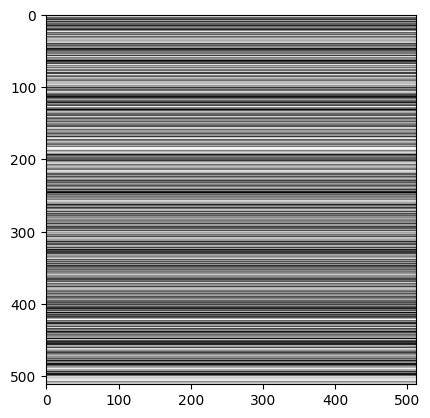

In [24]:
LogisticEncryption(image + ext, key = "guesssuperkey")
enc_res1 = Image.open(image + "_LogisticEnc.png", 'r')
imshow(np.asarray(enc_res1))

(10000, 224, 224)


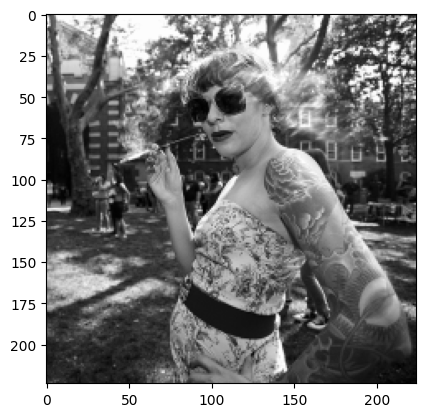

In [25]:
import matplotlib.pyplot as plt
import cv2
gray = np.load(gray_path)[:10000]
print(gray.shape)

def display(img):
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
decrypt1 = gray[0]
display(decrypt1)

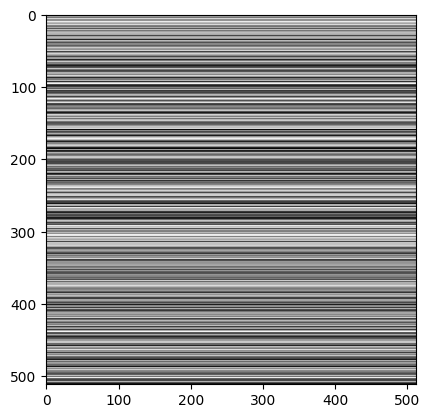

In [26]:
LogisticEncryption(image + ext, key = "supersecretkey")
enc_res2 = Image.open(image + "_LogisticEnc.png", 'r')
imshow(np.asarray(enc_res2))

(10000, 224, 224)


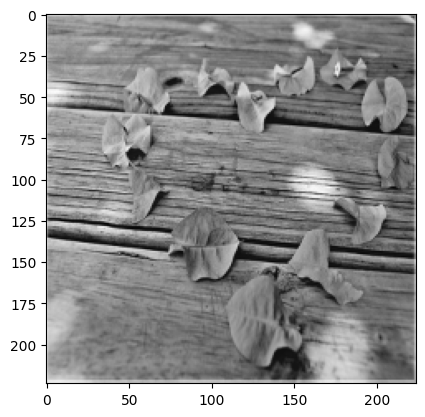

In [27]:
import matplotlib.pyplot as plt
import cv2
gray = np.load(gray_path)[:10000]
print(gray.shape)

def display(img):
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
decrypt2 = gray[1]
display(decrypt2)